In [2]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [3]:
data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path)
rna = data['rna_train']
atac = data['atac_train_small']

In [4]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

In [5]:
print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

rna zero frac: 0.0
atac zero frac: 0.9740022531413609


In [63]:
from sklearn.decomposition import PCA

def test_pca_reconstruction(arr, n_components):
    baseline = np.var(arr)*arr.size # mse for mean prediction
    pca = PCA(n_components=n_components)
    pca.fit(arr)
    trans = pca.transform(arr)
    recon = pca.inverse_transform(trans)
    mse = ((arr - recon)*(arr - recon)).sum()
    return mse/baseline

In [69]:
mses = []
n_vals = [10*(2**k) for k in range(9)]
for n_components in n_vals:
    mses.append(test_pca_reconstruction(atac, n_components))

In [70]:
import pandas as pd
pca_recon_df = pd.DataFrame()
pca_recon_df['Normalized MSE'] = mses
pca_recon_df['Number of PCA Components'] = n_vals

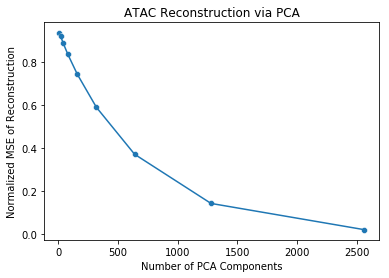

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
sns.lineplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
ax.set(ylabel='Normalized MSE of Reconstruction', title='ATAC Reconstruction via PCA')
plt.savefig('atac_pca_recon.png', dpi=300)

In [78]:
pca_recon_df.to_csv('atac_pca_recon_experiment.csv', index=False)

In [77]:
atac.shape

(6897, 3808)

In [81]:
mses = []
n_vals = [10*(2**k) for k in range(9)]
for n_components in n_vals:
    mses.append(test_pca_reconstruction(rna, n_components))
    
import pandas as pd
pca_recon_df = pd.DataFrame()
pca_recon_df['Normalized MSE'] = mses
pca_recon_df['Number of PCA Components'] = n_vals
pca_recon_df.to_csv('rna_pca_recon_experiment.csv', index=False)

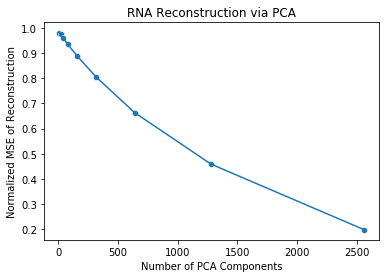

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
sns.lineplot(data=pca_recon_df, x='Number of PCA Components', y='Normalized MSE')
ax.set(ylabel='Normalized MSE of Reconstruction', title='RNA Reconstruction via PCA')
plt.savefig('rna_pca_recon.png', dpi=300)

In [86]:
rna_df = pd.read_csv('rna_pca_recon_experiment.csv')
atac_df = pd.read_csv('atac_pca_recon_experiment.csv')

In [89]:
merged = pd.DataFrame()
merged['Number of PCA Components'] = rna_df['Number of PCA Components']
merged['RNA'] = rna_df['Normalized MSE']
merged['ATAC'] = atac_df['Normalized MSE']
merged.to_csv('rna_atac_recon.csv', index=False)

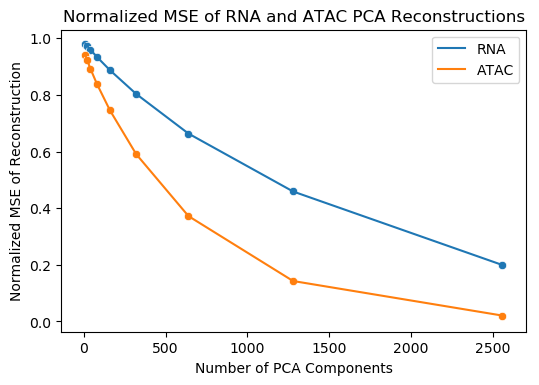

In [103]:
ax = sns.scatterplot(data=merged, x='Number of PCA Components', y='RNA')
sns.scatterplot(data=merged, x='Number of PCA Components', y='ATAC')
sns.lineplot(data=merged, x='Number of PCA Components', y='RNA', label='RNA')
sns.lineplot(data=merged, x='Number of PCA Components', y='ATAC', label='ATAC')
ax.set(ylabel='Normalized MSE of Reconstruction', title='Normalized MSE of RNA and ATAC PCA Reconstructions')
plt.savefig('rna_atac_recon.png', dpi=300)

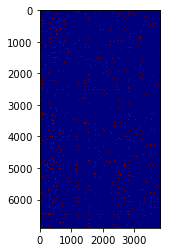

In [14]:
import matplotlib.pyplot as plt

plt.imshow(atac, cmap='jet')

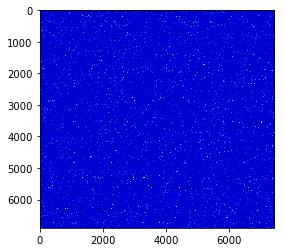

In [15]:
plt.imshow(rna, cmap='jet')

2

In [5]:
list(data.keys())

['peak_selector',
 'atac_train_small',
 'atac_test_small',
 'rna_train',
 'rna_test',
 'rna_good_feats',
 'train_idx',
 'test_idx',
 'cell_type_train',
 'cell_type_test']

In [11]:
import torch

In [12]:
atac = torch.Tensor(atac).to('cuda:0')
rna = torch.Tensor(rna).to('cuda:0')

In [13]:
atac_corr = atac.T @ atac

In [14]:
rna_corr = rna.T @ rna

In [26]:
print(zero_frac(atac_corr.cpu().numpy()))
print(zero_frac(rna_corr.cpu().numpy()))

0.2509580118812231
0.0


In [27]:
embeddings_root = '/om2/user/rogerjin/GANOLI/ganoli/embeddings'
embeddings_corr_dir = f'{embeddings_root}/corr'

atac_corr_path = f'{embeddings_corr_dir}/atac.pt'
rna_corr_path = f'{embeddings_corr_dir}/rna.pt'

torch.save(atac_corr, atac_corr_path)
torch.save(rna_corr, rna_corr_path)

In [29]:
list(data.keys())

['peak_selector',
 'atac_train_small',
 'atac_test_small',
 'rna_train',
 'rna_test',
 'rna_good_feats',
 'train_idx',
 'test_idx',
 'cell_type_train',
 'cell_type_test']

In [34]:
print(data['rna_good_feats'].shape)
print(data['rna_good_feats'].sum())
data['rna_good_feats']

(18704,)
7445


array([ True,  True, False, ..., False, False, False])

In [35]:
print(data['peak_selector'].shape)
print(data['peak_selector'].sum())
data['peak_selector']

(104510,)
3808


array([False, False, False, ..., False, False, False])

In [53]:
import pandas as pd
gene_list = pd.read_csv(f'{data_root}/gene_list.csv', header=None)

In [66]:
chosen_genes = gene_list[data['rna_good_feats']]

In [ ]:
list(chosen_genes[1])

In [1]:
from os.path import join as opj
import numpy as np

data_root = '/om2/user/rogerjin/data'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
cell_labels_train = data['cell_type_train']

In [2]:
cell_labels_train.shape

(6897,)

In [3]:
from GanoliModel import GanoliShallowGAN

Global seed set to 42


In [4]:
gan = GanoliShallowGAN(7445, 3808)

In [82]:
%load_ext autoreload
%autoreload 2

In [6]:
checkpoint_path = '/om2/user/rogerjin/GANOLI/ganoli/models/logs/shallow/default/version_5/checkpoints/epoch=17-val_oracle_total=1.73.ckpt'
ckpt_model = GanoliShallowGAN.load_from_checkpoint(checkpoint_path=checkpoint_path, rna_shape=7445, atac_shape=3808)

In [16]:
ckpt_model.to('cuda:0')

GanoliShallowGAN(
  (generator_rna2atac): GanoliShallowGenerator(
    (linear1): Linear(in_features=7445, out_features=500, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=500, out_features=3808, bias=True)
  )
  (generator_atac2rna): GanoliShallowGenerator(
    (linear1): Linear(in_features=3808, out_features=500, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=500, out_features=7445, bias=True)
  )
  (discriminator_rna): GanoliShallowDiscriminator(
    (linear1): Linear(in_features=7445, out_features=500, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=500, out_features=1, bias=True)
  )
  (discriminator_atac): GanoliShallowDiscriminator(
    (linear1): Linear(in_features=3808, out_features=500, bias=True)
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (linear2): Linear(in_features=500, out_features=1, bias=True)
  )
  (reconstruction_loss_fn

In [8]:
atac_val = data['atac_test_small']

In [9]:
import torch
atac_val = torch.Tensor(atac_val).to('cuda:0')

In [14]:
atac_val_mini = atac_val[:10, :]

In [19]:
rna_val_pred = ckpt_model(atac_val,data_type='atac')

In [21]:
rna_val_pred.shape

torch.Size([2300, 7445])

In [22]:
rna_val_labels = data['cell_type_test']

In [27]:
import umap
reducer = umap.UMAP(densmap=True) 
rna_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())

In [30]:
rna_trans.shape

(2300, 2)

In [28]:
import benplot

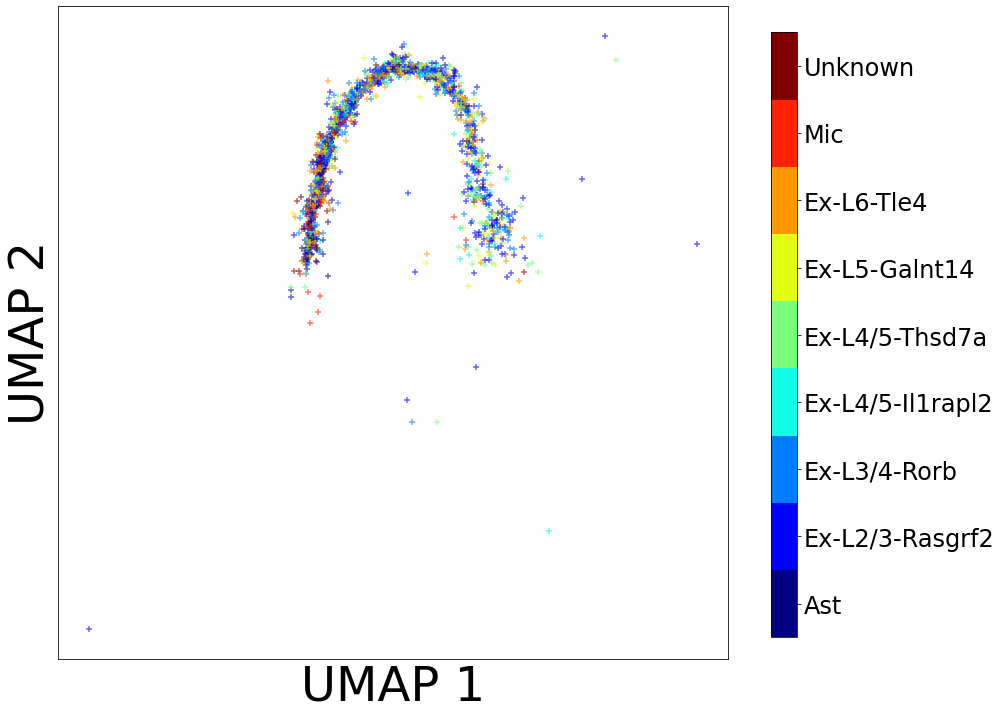

In [31]:
benplot.plot_lowdim_rep(rna_trans, rna_val_labels)

In [36]:
rna_val = data['rna_test']
reducer = umap.UMAP(densmap=True, min_dist=0.001) 
rna_true_trans = reducer.fit_transform(rna_val)

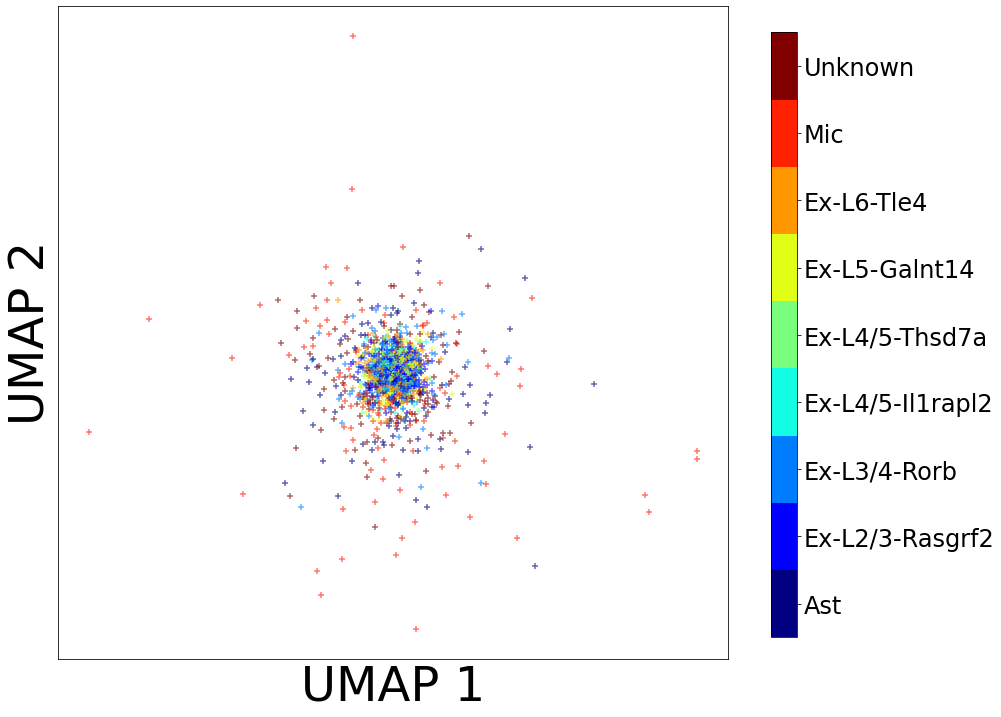

In [37]:
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

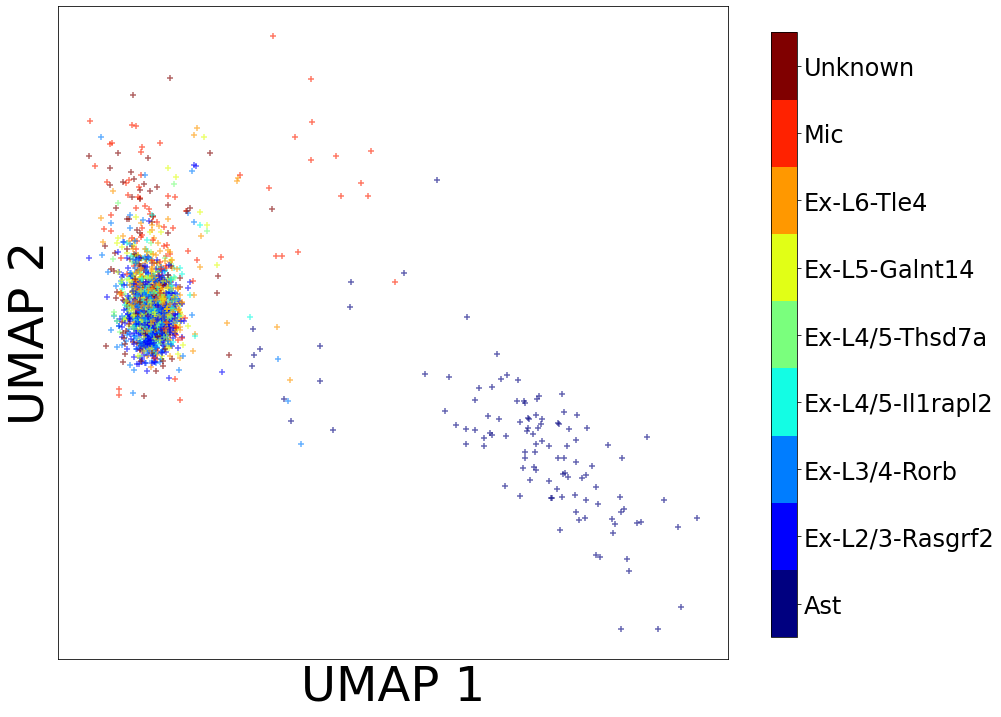

In [38]:
from sklearn.decomposition import PCA

rna_val = data['rna_test']
reducer = PCA(n_components=2) 
rna_true_trans = reducer.fit_transform(rna_val)
benplot.plot_lowdim_rep(rna_true_trans, rna_val_labels)

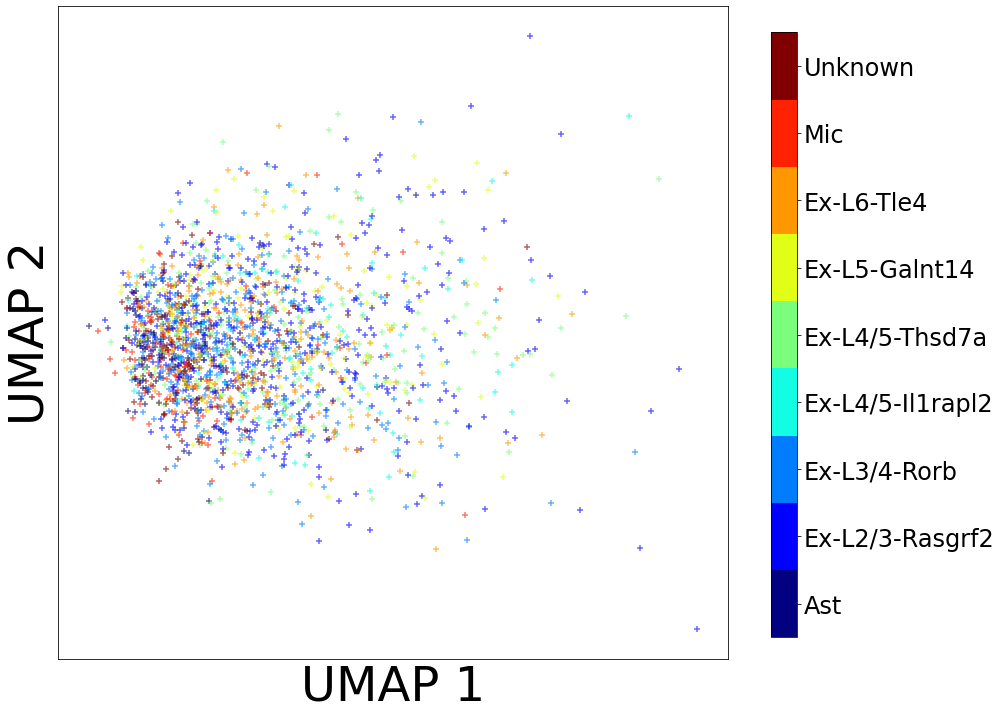

In [41]:
rna_pred_trans = reducer.fit_transform(rna_val_pred.detach().cpu().numpy())
benplot.plot_lowdim_rep(rna_pred_trans, rna_val_labels)

In [44]:
rna_val = torch.Tensor(rna_val).to('cuda:0')
atac_val_pred = ckpt_model(rna_val,data_type='rna')

In [46]:
atac_val_pred

torch.Size([2300, 3808])

In [48]:
atac_val_pred

tensor([[ 0.0309,  0.0096,  0.2052,  ..., -0.0586,  0.1369,  0.2671],
        [ 0.0721,  0.2498,  0.8023,  ..., -0.8574,  0.7168,  0.8470],
        [-0.0562,  0.3003,  0.5561,  ..., -0.6264,  0.5306,  0.7460],
        ...,
        [ 0.1839,  0.1454,  0.3706,  ..., -0.3901,  0.1009,  0.5642],
        [ 0.4542,  0.0702,  0.8702,  ..., -0.1509,  0.1980,  1.2874],
        [-0.0638, -0.1454,  0.0921,  ..., -0.0924,  0.0267,  0.0629]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [52]:
type(atac_val)

torch.Tensor

In [53]:
from sklearn.metrics import roc_auc_score
import pandas as pd

aurocs = []
for i in range(atac_val.shape[1]):
    auroc = roc_auc_score(atac_val[:, i].detach().cpu().numpy(), atac_val_pred[:, i].detach().cpu().numpy())
    aurocs.append(auroc)

atac_rocs = pd.DataFrame()
atac_rocs['auroc'] = aurocs

array([[<AxesSubplot:title={'center':'auroc'}>]], dtype=object)

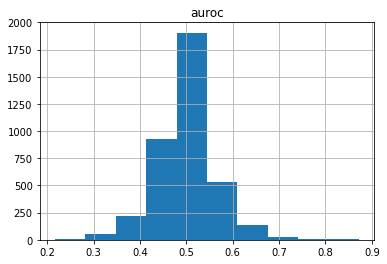

In [57]:
atac_rocs.hist()

In [58]:
atac_rocs.mean()

auroc    0.501089
dtype: float64